In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from Data import DataLoader
from DataLoader import Data
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from sklearn.feature_selection import mutual_info_classif
df=Data.load_data('music.csv')

trainx,testx,trainy,testy=Data.prepare_data(df,label_dict={
    'final_blues':0,
    'final_classical':1,
    'final_country':2,
    'final_disco':3,
    'final_hiphop':4,
    'final_jazz':5,
    'final_metal':6,
    'final_pop':7,
    'final_reggae':8,
    'final_rock':9
})    

Data Loaded, Shape : 10000 ,343


In [8]:

class Model:
    def __init__(self,input_shape,num_classes,dropout_p):
        self.input_shape=input_shape
        self.num_classes=num_classes
        self.drop=dropout_p

    def build_model(self):
       inputs=tf.keras.Input(shape=self.input_shape)
       layer1=tf.keras.layers.Dense(512,activation='relu')(inputs)
       layer2=tf.keras.layers.Dense(1024,activation='relu')(layer1)
       layer3=tf.keras.layers.Dense(2048,activation='relu')(layer2)
       layer4=tf.keras.layers.Dropout(rate=self.drop)(layer3)
       layer5=tf.keras.layers.Dense(512,activation='relu')(layer4)
       layer6=tf.keras.layers.Dropout(rate=self.drop)(layer5)
       layer5=tf.keras.layers.Dense(self.num_classes,activation='softmax')(layer6)
       model=tf.keras.Model(inputs=inputs,outputs=layer5)

       return model
    
model=Model(input_shape=(341),num_classes=10,dropout_p=.5)
model=model.build_model()
print(model.summary())
params={
    'batch_size':64,
    'epochs':40,
    'validation_split':0.2
}
def train_model(model,trainx,trainy,params):
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('.stacking_mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')    
    model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics='acc')
    model.fit(trainx,trainy,batch_size=params['batch_size'],validation_split=params['validation_split'],epochs=params['epochs'],callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
epochs = [20,25,30]
learning_rate = [1e-2, 1e-3, 1e-4, 2e-5, 5e-5]
weight_decay = [1e-4, 1e-4, 1e-5]
dropout_probs = [0.2,0.3,0.4]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 341)]             0         
                                                                 
 dense_11 (Dense)            (None, 512)               175104    
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0   

In [24]:
class tabular_config:
    NUM_MODELS = 20
import random
parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
    "dropout_prob" : random.choice(dropout_probs) 
} for count in range(tabular_config.NUM_MODELS)]

parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
    "dropout_prob" : random.choice(dropout_probs) 
} for count in range(tabular_config.NUM_MODELS)]
from tqdm import tqdm
## creating a dataframe for parameters
music_params = pd.DataFrame(parameters)
import os
import gc
gc.collect()

model_paths = []
test_scores = []
X_train=trainx
y_train=trainy
X_test=testx
y_test=testy
## Training models with different parameters
for params in tqdm(parameters):
    model_save_path, test_score = music_training((X_train, y_train), 
                                                 (X_test, y_test),
                                                 params["epochs"], 
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 params["dropout_prob"],
                                                 save_dir = "music/")
    
    model_paths.append(model_save_path)
    test_scores.append(test_score)

## saving scores and model paths to dataframe
music_params["paths"] = model_paths
music_params["scores"] = test_scores


## soring scores in descending order
music_params.sort_values(by = "scores", ascending= False, inplace = True)
music_params.reset_index(drop = True, inplace = True)

## saving params with respective scores and model paths
music_params.to_csv("music_params.csv", index = False)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

63/63 [==============================] - 1s 7ms/step - loss: 0.5840 - accuracy: 0.9045



  5%|████                                                                            | 1/20 [08:47<2:46:56, 527.17s/it]

63/63 [==============================] - 1s 8ms/step - loss: 2.1061 - accuracy: 0.1530



 10%|████████                                                                        | 2/20 [18:37<2:49:17, 564.33s/it]

63/63 [==============================] - 1s 8ms/step - loss: 0.2667 - accuracy: 0.9355



 15%|████████████                                                                    | 3/20 [27:32<2:36:04, 550.84s/it]

63/63 [==============================] - 1s 9ms/step - loss: 2.0938 - accuracy: 0.1940



 20%|████████████████                                                                | 4/20 [38:36<2:38:46, 595.40s/it]

63/63 [==============================] - 1s 12ms/step - loss: 0.2898 - accuracy: 0.9230



 25%|████████████████████                                                            | 5/20 [47:20<2:22:29, 570.00s/it]

63/63 [==============================] - 2s 21ms/step - loss: 0.2638 - accuracy: 0.9240



 30%|██████████████████████▊                                                     | 6/20 [5:59:42<26:14:36, 6748.33s/it]

63/63 [==============================] - 1s 13ms/step - loss: 2.3035 - accuracy: 0.1060



 35%|██████████████████████████▌                                                 | 7/20 [6:08:22<17:00:59, 4712.30s/it]

63/63 [==============================] - 1s 10ms/step - loss: 2.1057 - accuracy: 0.1885



 40%|██████████████████████████████▍                                             | 8/20 [6:16:22<11:12:56, 3364.74s/it]

63/63 [==============================] - 1s 15ms/step - loss: 0.2549 - accuracy: 0.9470



 45%|██████████████████████████████████▋                                          | 9/20 [6:28:47<7:46:42, 2545.69s/it]

63/63 [==============================] - 1s 10ms/step - loss: 2.0657 - accuracy: 0.2180



 50%|██████████████████████████████████████                                      | 10/20 [6:38:55<5:24:35, 1947.51s/it]

63/63 [==============================] - 1s 9ms/step - loss: 0.3674 - accuracy: 0.8785



 55%|█████████████████████████████████████████▊                                  | 11/20 [6:47:05<3:45:14, 1501.67s/it]

63/63 [==============================] - 1s 10ms/step - loss: 0.2733 - accuracy: 0.9300



 60%|█████████████████████████████████████████████▌                              | 12/20 [6:54:24<2:37:05, 1178.13s/it]

63/63 [==============================] - 1s 9ms/step - loss: 0.3045 - accuracy: 0.9220



 65%|██████████████████████████████████████████████████                           | 13/20 [7:03:30<1:55:07, 986.73s/it]

63/63 [==============================] - 1s 9ms/step - loss: 0.3973 - accuracy: 0.9200



 70%|█████████████████████████████████████████████████████▉                       | 14/20 [7:14:33<1:28:53, 888.84s/it]

63/63 [==============================] - 1s 11ms/step - loss: 0.2584 - accuracy: 0.9400



 75%|█████████████████████████████████████████████████████████▊                   | 15/20 [7:25:47<1:08:41, 824.24s/it]

63/63 [==============================] - 1s 8ms/step - loss: 0.2699 - accuracy: 0.9400



 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [7:34:25<48:48, 732.11s/it]

63/63 [==============================] - 1s 8ms/step - loss: 0.3557 - accuracy: 0.8820



 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [7:40:46<31:19, 626.34s/it]

63/63 [==============================] - 1s 9ms/step - loss: 0.3882 - accuracy: 0.9185



 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [7:49:17<19:43, 591.70s/it]

63/63 [==============================] - 1s 7ms/step - loss: 2.2753 - accuracy: 0.1315



 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [7:59:59<10:07, 607.05s/it]

63/63 [==============================] - 1s 7ms/step - loss: 1.6038 - accuracy: 0.4190


100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [8:08:36<00:00, 1465.83s/it]


0%|                                                                                           | 0/20 [00:00<?, ?it/s]
63/63 [==============================] - 1s 7ms/step - loss: 0.5840 - accuracy: 0.9045

  5%|████                                                                            | 1/20 [08:47<2:46:56, 527.17s/it]
63/63 [==============================] - 1s 8ms/step - loss: 2.1061 - accuracy: 0.1530

 10%|████████                                                                        | 2/20 [18:37<2:49:17, 564.33s/it]
63/63 [==============================] - 1s 8ms/step - loss: 0.2667 - accuracy: 0.9355

 15%|████████████                                                                    | 3/20 [27:32<2:36:04, 550.84s/it]
63/63 [==============================] - 1s 9ms/step - loss: 2.0938 - accuracy: 0.1940

 20%|████████████████                                                                | 4/20 [38:36<2:38:46, 595.40s/it]
63/63 [==============================] - 1s 12ms/step - loss: 0.2898 - accuracy: 0.9230

 25%|████████████████████                                                            | 5/20 [47:20<2:22:29, 570.00s/it]
63/63 [==============================] - 2s 21ms/step - loss: 0.2638 - accuracy: 0.9240

 30%|██████████████████████▊                                                     | 6/20 [5:59:42<26:14:36, 6748.33s/it]
63/63 [==============================] - 1s 13ms/step - loss: 2.3035 - accuracy: 0.1060

 35%|██████████████████████████▌                                                 | 7/20 [6:08:22<17:00:59, 4712.30s/it]
63/63 [==============================] - 1s 10ms/step - loss: 2.1057 - accuracy: 0.1885

 40%|██████████████████████████████▍                                             | 8/20 [6:16:22<11:12:56, 3364.74s/it]
63/63 [==============================] - 1s 15ms/step - loss: 0.2549 - accuracy: 0.9120

 45%|██████████████████████████████████▋                                          | 9/20 [6:28:47<7:46:42, 2545.69s/it]
63/63 [==============================] - 1s 10ms/step - loss: 2.0657 - accuracy: 0.2180

 50%|██████████████████████████████████████                                      | 10/20 [6:38:55<5:24:35, 1947.51s/it]
63/63 [==============================] - 1s 9ms/step - loss: 0.3674 - accuracy: 0.8785

 55%|█████████████████████████████████████████▊                                  | 11/20 [6:47:05<3:45:14, 1501.67s/it]
63/63 [==============================] - 1s 10ms/step - loss: 0.2733 - accuracy: 0.9300

 60%|█████████████████████████████████████████████▌                              | 12/20 [6:54:24<2:37:05, 1178.13s/it]
63/63 [==============================] - 1s 9ms/step - loss: 0.3045 - accuracy: 0.9220

 65%|██████████████████████████████████████████████████                           | 13/20 [7:03:30<1:55:07, 986.73s/it]
63/63 [==============================] - 1s 9ms/step - loss: 0.3973 - accuracy: 0.9200

 70%|█████████████████████████████████████████████████████▉                       | 14/20 [7:14:33<1:28:53, 888.84s/it]
63/63 [==============================] - 1s 11ms/step - loss: 0.2584 - accuracy: 0.9400

 75%|█████████████████████████████████████████████████████████▊                   | 15/20 [7:25:47<1:08:41, 824.24s/it]
63/63 [==============================] - 1s 8ms/step - loss: 0.2699 - accuracy: 0.9400

 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [7:34:25<48:48, 732.11s/it]
63/63 [==============================] - 1s 8ms/step - loss: 0.3557 - accuracy: 0.8820

 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [7:40:46<31:19, 626.34s/it]
63/63 [==============================] - 1s 9ms/step - loss: 0.3882 - accuracy: 0.9185

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [7:49:17<19:43, 591.70s/it]
63/63 [==============================] - 1s 7ms/step - loss: 2.2753 - accuracy: 0.1315

 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [7:59:59<10:07, 607.05s/it]
63/63 [==============================] - 1s 7ms/step - loss: 1.6038 - accuracy: 0.4190
100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [8:08:36<00:00, 1465.83s/it]

In [33]:

def uniform_soup(model_paths, test_ds, evaluate_fun, disable_tqdm = False):
    """
    Returns Uniform Soup model and accuracy on test set 
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    disable_tqdm : Bool, Wheter to disable TQDM Progress bar or not
    """
    
    soups = []
    ## Instantiating model
    
    tf.keras.backend.clear_session()
    M=Model(input_shape=(341),num_classes=10,dropout_p=0.5)
    model = M.build_model()
    
    
    ## Iterating Over all models 
    for path in tqdm(model_paths, disable=disable_tqdm):
        
        ## loading model wieghts 
        model.load_weights(path)
        
        ## Adding model weights in soup list
        soup = [np.array(weights) for weights in model.weights]
        soups.append(soup)
        
    ## Averaing all weights 
    mean_soup = np.array(soups).mean(axis = 0)
    
    ## Replacing model's weight with Unifrom Soup Weights
    for w1, w2 in zip(model.weights, mean_soup ):
        tf.keras.backend.set_value(w1, w2)
        
    ## evaluating uniform soup performance   
    accuracy =  evaluate_fun(model, test_ds)
    return model, accuracy

def greedy_soup(model_paths, test_ds, evaluate_fun):
    """
    Returns Greedy Soup model and accuracy on test set 
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    """
    ## Creating intial soup with best performing model 
    soups =  [model_paths[0]]
    
    ## Instantiating model
    
    tf.keras.backend.clear_session()
    M=Model(input_shape=(341),num_classes=10,dropout_p=0.5)
    model = M.build_model()
 
    ## Loading best performing model's weights 
    model.load_weights(model_paths[0])
    
    ## Scoirng best performing model on test set 
    score_final = evaluate_fun(model,test_ds)
    
    ## Iterating over the remaining models 
    for path in tqdm(model_paths[1:]):
        
        ## Creating a temp soup 
        temp_soup =  soups.copy()
        temp_soup.append(path)
        
        ## Getting score from temp soup
        model, score = uniform_soup(temp_soup,test_ds, evaluate_fun, disable_tqdm= True)
        
        ## Conditioning current model for appneding in main soup
        ## if score from the temp soup is more than best perofming model
        ## the temp soup path is appended to main soup 
        if score > score_final:
            score_final = score
            soups.append(path)
    model,_=uniform_soup(soups,test_ds,evaluate_fun,disable_tqdm= True)
    return model, score_final

def music_training(train_ds, 
                   test_ds,
                   epochs, 
                   learning_rate, 
                   weight_decay,
                   dropout_prob,
                   save_dir = "music/"):
    """
    Returns Saved trained model's path and test evaluation score
    Args:
    train_ds : Train Dataset in tfds format.
    test_ds : Test Dataset in tfds format.
    epochs : Int, Trainig Epochs count.
    learning_rate : Float, Training Learning Rate
    weight_decay : Float, AdamW optimizer Weight Decay
    save_dir : Str, Model Save Directory Prefix
    """
    ## Creating directory for saving models
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    ## AdamW Optimizer Setup    
    adamw_optimizer = tf.optimizers.Adam(
                                     learning_rate= learning_rate)
    
    ## Instantiating model
    tf.keras.backend.clear_session()
    M=Model(input_shape=(341),num_classes=10,dropout_p=dropout_prob)
    model = M.build_model()
    ## Compiling Model
    model.compile(
            
            optimizer = adamw_optimizer,
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"]
        )
    
    ## Training Model
    model.fit(
        train_ds[0],
        train_ds[1],
        epochs = epochs,
        verbose = 0
    )
    
    ## Evaluating Model
    test_loss , test_score  = model.evaluate(test_ds[0], test_ds[1], verbose = 1 )
    
    ## Saving Trained Model
    model_save_path =save_dir +  save_dir + "music-"  +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + ".h5"
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## if model with same parameter already exists
        model_save_path = save_dir + "music-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + str(random.choice(np.arange(0,1000))) +  ".h5"
        model.save_weights(model_save_path)
        
    ## Clearing GPU memory
    del model 
    gc.collect()
    return model_save_path, test_score

def music_eval(model,test_ds):
    """
    Returns Accuracy of model on test set 
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    preds = model.predict(test_ds[0])
    preds=np.argmax(preds,axis=1)
    acc=accuracy_score(testy,preds)
    return acc

In [35]:
greedy_soup_model, greedy_soup_acc = greedy_soup(
    music_params["paths"].values, 
    (X_test,y_test),
    music_eval
)
print("Accuracy of Greedy Soup:", greedy_soup_acc)

63/63 [==============================] - 1s 7ms/step



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

63/63 [==============================] - 1s 7ms/step



  5%|████▎                                                                              | 1/19 [00:00<00:14,  1.28it/s]

63/63 [==============================] - 0s 7ms/step



 11%|████████▋                                                                          | 2/19 [00:01<00:13,  1.29it/s]

63/63 [==============================] - 1s 7ms/step



 16%|█████████████                                                                      | 3/19 [00:02<00:12,  1.29it/s]

63/63 [==============================] - 0s 7ms/step



 21%|█████████████████▍                                                                 | 4/19 [00:03<00:11,  1.29it/s]

63/63 [==============================] - 1s 7ms/step



 26%|█████████████████████▊                                                             | 5/19 [00:03<00:10,  1.30it/s]

63/63 [==============================] - 1s 7ms/step



 32%|██████████████████████████▏                                                        | 6/19 [00:04<00:10,  1.29it/s]

63/63 [==============================] - 1s 8ms/step



 37%|██████████████████████████████▌                                                    | 7/19 [00:05<00:09,  1.25it/s]

63/63 [==============================] - 1s 7ms/step



 42%|██████████████████████████████████▉                                                | 8/19 [00:06<00:08,  1.24it/s]

63/63 [==============================] - 1s 7ms/step



 47%|███████████████████████████████████████▎                                           | 9/19 [00:07<00:08,  1.23it/s]

63/63 [==============================] - 1s 8ms/step



 53%|███████████████████████████████████████████▏                                      | 10/19 [00:08<00:07,  1.19it/s]

63/63 [==============================] - 1s 8ms/step



 58%|███████████████████████████████████████████████▍                                  | 11/19 [00:08<00:06,  1.18it/s]

63/63 [==============================] - 0s 7ms/step



 63%|███████████████████████████████████████████████████▊                              | 12/19 [00:09<00:05,  1.21it/s]

63/63 [==============================] - 1s 7ms/step



 68%|████████████████████████████████████████████████████████                          | 13/19 [00:10<00:04,  1.20it/s]

63/63 [==============================] - 1s 8ms/step



 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [00:11<00:04,  1.18it/s]

63/63 [==============================] - 1s 7ms/step



 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [00:12<00:03,  1.20it/s]

63/63 [==============================] - 1s 7ms/step



 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [00:13<00:02,  1.22it/s]

63/63 [==============================] - 1s 7ms/step



 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [00:13<00:01,  1.23it/s]

63/63 [==============================] - 1s 7ms/step



 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [00:14<00:00,  1.24it/s]

63/63 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.23it/s]

Accuracy of Greedy Soup: 0.947


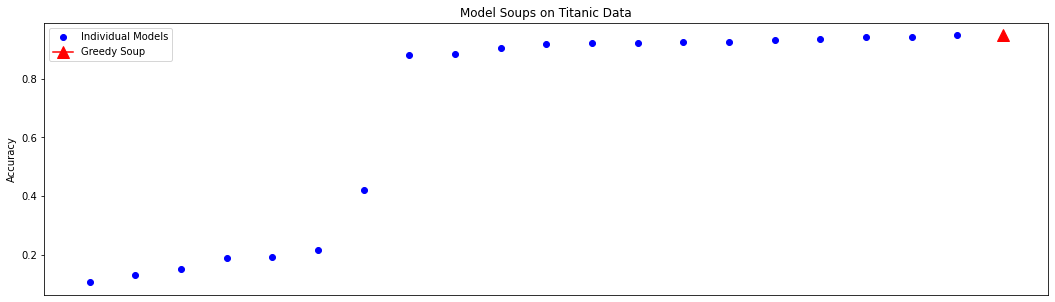

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (18,5))
plt.plot( music_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( len(music_params), greedy_soup_acc,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("Accuracy")
plt.title("Model Soups on music Data")
plt.legend()